# in this notebook let's do some basic EDA, to explore the trends

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%run /Users/yaoyao/Documents/datascience/toolbox/toolbox1_dataview.ipynb
%matplotlib inline

## read in data

In [2]:
with open('train.csv') as f:
    raw_train = pd.read_csv(f)
with open('test.csv') as f:
    raw_test = pd.read_csv(f)
with open('train_labels.csv') as f:
    raw_train_labels = pd.read_csv(f)

## clean the train data
- as instructed, train data contains istallation_id which never take assessments, while test data has at least one
- so we need to remove these data from the train

In [3]:
def cleantrain(raw_train):
    # 1.get installation_id with only one game session
    # all records doing assessments
    astrain = raw_train[raw_train['type'] == 'Assessment'].loc[:,['installation_id','game_session']]
    # all insid ever done assessment
    inid2keep = astrain.groupby('installation_id').count().index
    train = raw_train[raw_train['installation_id'].isin(inid2keep)]
    
    # 2. convert timestamp
    # The T is just a literal to separate the date from the time, 
    # and the Z means "zero hour offset" also known as "Zulu time" (UTC).
    ts = pd.to_datetime(train.iloc[:,2])
    train.insert(0,'ts',ts)
    train.insert(1,'hour',ts.dt.hour)
    train.insert(2,'dayofweek',ts.dt.dayofweek)
    return train

In [4]:
train = cleantrain(raw_train)
# reduce records from 124e6 to 91 e6
# now the train and test should be ~same distribution

## varify the distribution of train and test

In [22]:
def plot_dis(train,raw_test):
    plottest = raw_test.loc[:,['installation_id','game_session']].groupby(['installation_id']).count()
    plottrain = train.loc[:,['installation_id','game_session']].groupby(['installation_id']).count()
    plottest2 = raw_test[raw_test['type'] == 'Assessment'].loc[:,['installation_id','game_session']].groupby(['installation_id']).count()
    plottrain2 = train[train['type'] == 'Assessment'].loc[:,['installation_id','game_session']].groupby(['installation_id']).count()
    figs, axes = plt.subplots(1,2,figsize=(10,4))
    sns.distplot(plottest.game_session,label='test',ax = axes[0])
    sns.distplot(plottrain.game_session,label='train',ax = axes[0])
    axes[0].legend(ncol=2, loc="lower right", frameon=True)
    axes[0].set(xlabel="# of game_sessions",ylabel="distribution",title = 'distribution of # of game_sessions per insid')
    
    sns.distplot(plottest2.game_session,label='test',ax = axes[1])
    sns.distplot(plottrain2.game_session,label='train',ax = axes[1])
    axes[1].legend(ncol=2, loc="lower right", frameon=True)
    axes[1].set(xlabel="# of asses_sessions",ylabel="distribution",title = 'distribution of # of asses_sessions per insid')

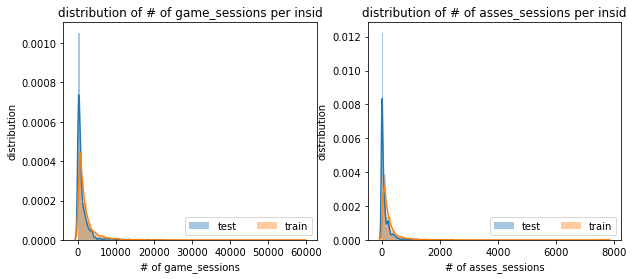

In [23]:
plot_dis(train,raw_test)
# the distribution is almost the same :) good

## now let's explore the time features

In [92]:
def plot_timestamp_train(train):
    figs,axes = plt.subplots(4,1,figsize=(20,10))
    #1, # of game sessions per hour
    pdata = train.loc[:,['game_session','hour']].groupby('hour').count().reset_index()
    sns.barplot(x='hour',y='game_session',data=pdata,ax=axes[0])
    axes[0].set(title='# of all sessions per hour',xlabel='hour',ylabel='counts')
    # # of assessment sessions per hour
    pdata = train[train['type']=='Assessment'].loc[:,['game_session','hour']].groupby('hour').count().reset_index()
    sns.barplot(x='hour',y='game_session',data=pdata,ax=axes[1])
    axes[1].set(title='# of assess sessions per hour',xlabel='hour',ylabel='counts')
    # # of games per hour
    pdata = train[train['type']=='Game'].loc[:,['game_session','hour']].groupby('hour').count().reset_index()
    sns.barplot(x='hour',y='game_session',data=pdata,ax=axes[2])
    axes[2].set(title='# of Game sessions per hour',xlabel='hour',ylabel='counts')
    # of all sessions per day of week
    pdata = train.loc[:,['game_session','dayofweek']].groupby('dayofweek').count().reset_index()
    sns.barplot(x='dayofweek',y='game_session',data=pdata,ax=axes[3])
    axes[3].set(title='# of all sessions per dayofweek',xlabel='dayofweek',ylabel='counts')
    
    
    

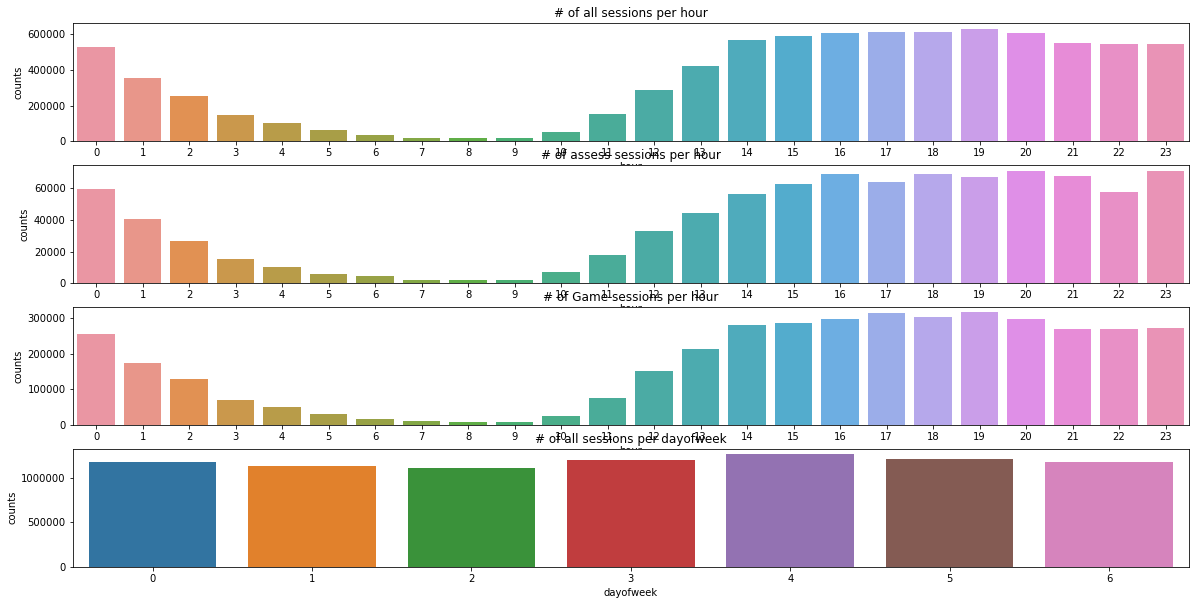

In [93]:
plot_timestamp_train(train)


- we can see clear pattern of the hour variation
- not so clear by the day of the week. consider us time zone?

## how about game time?

In [122]:
def plot_gametime(train):
    figs,axes = plt.subplots(2,1,figsize=(20,8))
    # average game time per app
    pld = train.loc[:,['title','game_time']].groupby(['title']).mean().reset_index()
    pld = pld[pld['game_time'] != 0]
    plotorder = pld.sort_values('game_time',ascending=False).title
    sns.barplot(x='title',y='game_time',data=pld,order = plotorder, ax = axes[0])
    axes[0].set(title = 'Average game time for every activity',xlabel='title',ylabel='avg game time (s)')
    axes[0].xaxis.set_tick_params(rotation=15,labelsize=10) 
    
    # for different type?
    pld = train.loc[:,['type','game_time']].groupby(['type']).mean().reset_index()
    plotorder = pld.sort_values('game_time',ascending=False).type
    sns.barplot(x='type',y='game_time',data=pld,order = plotorder, ax = axes[1])
    axes[1].set(title = 'Average game time for four types of activities',xlabel='type',ylabel='avg game time (s)')
    axes[1].xaxis.set_tick_params(rotation=15,labelsize=10) 
    

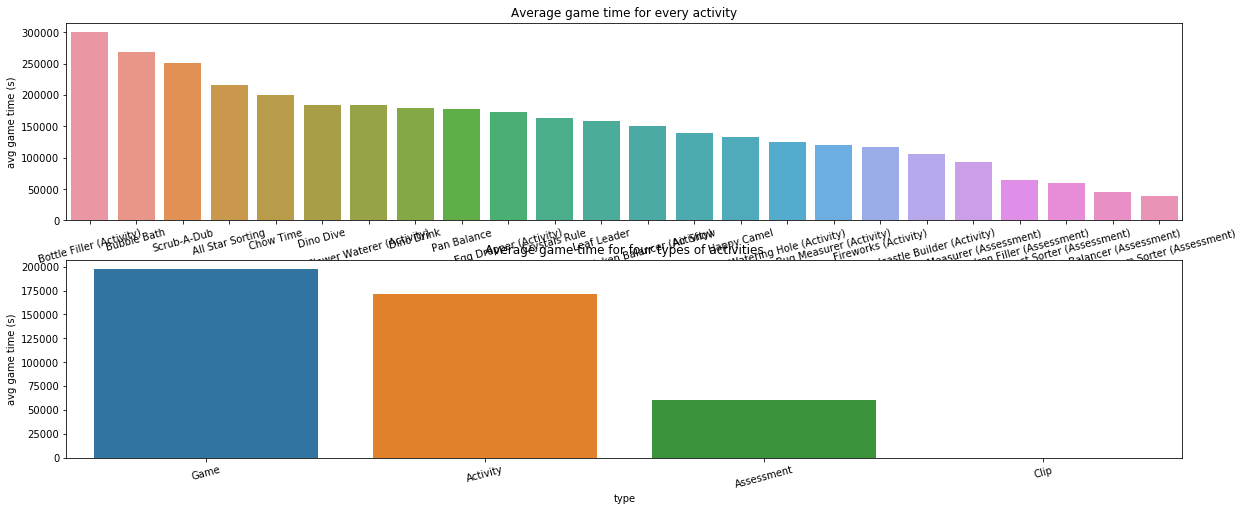

In [123]:
plot_gametime(train)

- well there are some popular activities
- kids love games other than assessment
- clip always have 0 play time

## how about the world?

In [129]:
def plot_world(train):
    figs,axes = plt.subplots(figsize=(20,8))
    # average game time per app
    pld = train.loc[:,['world','game_time']].groupby(['world']).mean().reset_index()
    pld = pld[pld['game_time'] != 0]
    plotorder = pld.sort_values('game_time',ascending=False).world
    sns.barplot(x='world',y='game_time',data=pld,order = plotorder, ax = axes)
    axes.set(title = 'Average game time for world',xlabel='world',ylabel='avg game time (s)')
    axes.xaxis.set_tick_params(rotation=15,labelsize=10) 
    
    

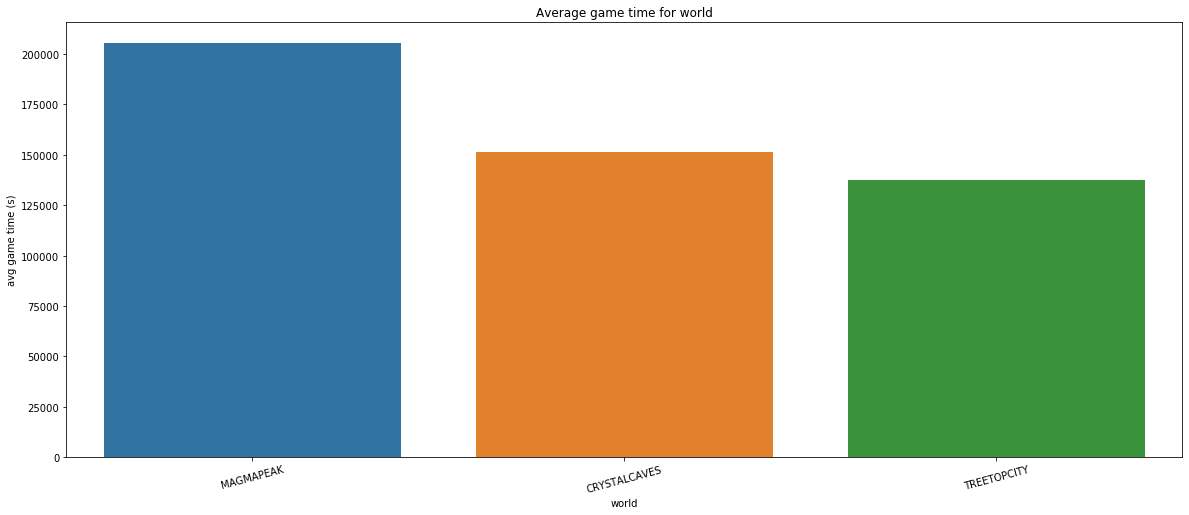

In [130]:
plot_world(train)

- only three world present, hard to tell from gametime itself

## since we're focusing on assessment, lets explore something about assessment

In [81]:
def plot_assess(train):
    # there are five assessments
    figs,axes = plt.subplots(3,1,figsize=(20,12))
    # average game time per assessment
    pld = train[train['type'] == 'Assessment'].loc[:,['title','game_time']].groupby(['title']).mean().reset_index()
    pld = pld[pld['game_time'] != 0]
    plotorder = pld.sort_values('game_time',ascending=False).title
    sns.barplot(x='title',y='game_time',data=pld,order = plotorder, ax = axes[0])
    axes[0].set(title = 'Average game time for different assessment',xlabel='title',ylabel='avg game time (s)')
    axes[0].xaxis.set_tick_params(rotation=0,labelsize=10)
    
    # total number of game sessions per assessment
    pld2 = train[train['type'] == 'Assessment'].loc[:,['title','game_session']].groupby(['title']).count().reset_index()
    sns.barplot(x='title',y='game_session',data = pld2, order = plotorder,ax = axes[1])
    axes[1].set(title = '# of game sessions per assessment',xlabel='title',ylabel='# of sessions')
    axes[1].xaxis.set_tick_params(rotation=0,labelsize=10)
    
    #
    gtsum = train[train['type'] == 'Assessment'].loc[:,['title','game_time']].groupby(['title']).sum().reset_index()    
    gtsum['avg'] = gtsum['game_time'] / pld2.game_session
    sns.barplot(x='title',y='avg',data = gtsum, order = plotorder,ax = axes[2])
    axes[2].set(title = 'avg gametime per session per assessment',xlabel='title'
                ,ylabel='avg game time per session of sessions')
    axes[2].xaxis.set_tick_params(rotation=0,labelsize=10)
    
    

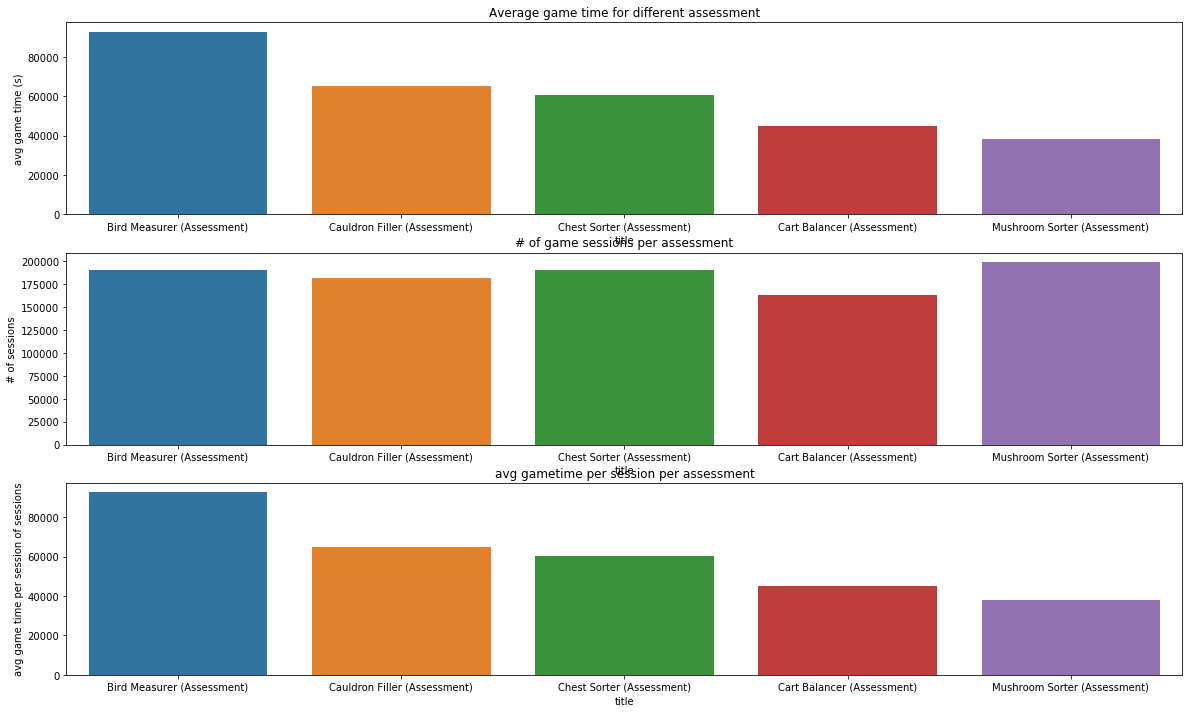

In [82]:
plot_assess(train)

- bird measurer takes the most play time to play, mushroom takes the least
- but mushroom has more game sessions opened
- but the difference in session numbers is small to affect the results of the average time per session for assessments. bird measure still most popular

In [226]:
def get_attempts(train):
    # first grep all records indicating attempts
    ttrain = train[train['type'] == 'Assessment']
    results = ttrain[(ttrain['title'] == 'Bird Measurer (Assessment)') & (ttrain['event_code'] == 4110)]
    results = results.append(ttrain[(ttrain['title'] != 'Bird Measurer (Assessment)') & (ttrain['event_code'] == 4100)])
    atmp = results.event_data.str.extract(r'("correct"):(\w+)')
    results.insert(6,'attempts',atmp.loc[:,1])
    mapping={"true":1,"false":0}
    results['atmp_binary'] = atmp_train['attempts'].map(mapping)
    
    return results
atmp_train=get_attempts(train)
    

In [211]:
def plot_attempts(train):
    
    #results.groupby(['title','attempts']).mean().reset_index()
    
    figs,axes = plt.subplots(2,1,figsize=(24,20))
    #
    sns.set(palette='muted',style="whitegrid", color_codes=True)
    sns.boxplot(x='title',y='game_time',hue='attempts',data=results,ax = axes[0])
    axes[0].set(title='game time for assessments based on the results',xlabel='title',ylabel='game time(ms)')
    axes[0].set_ylim(0,550000)

    sns.boxplot(x='title',y='game_time',data=results,ax = axes[1])
    axes[1].set(title='game event count for assessments based on the results',xlabel='title',ylabel='event_count')
    axes[1].set_ylim(0,400)
    
    

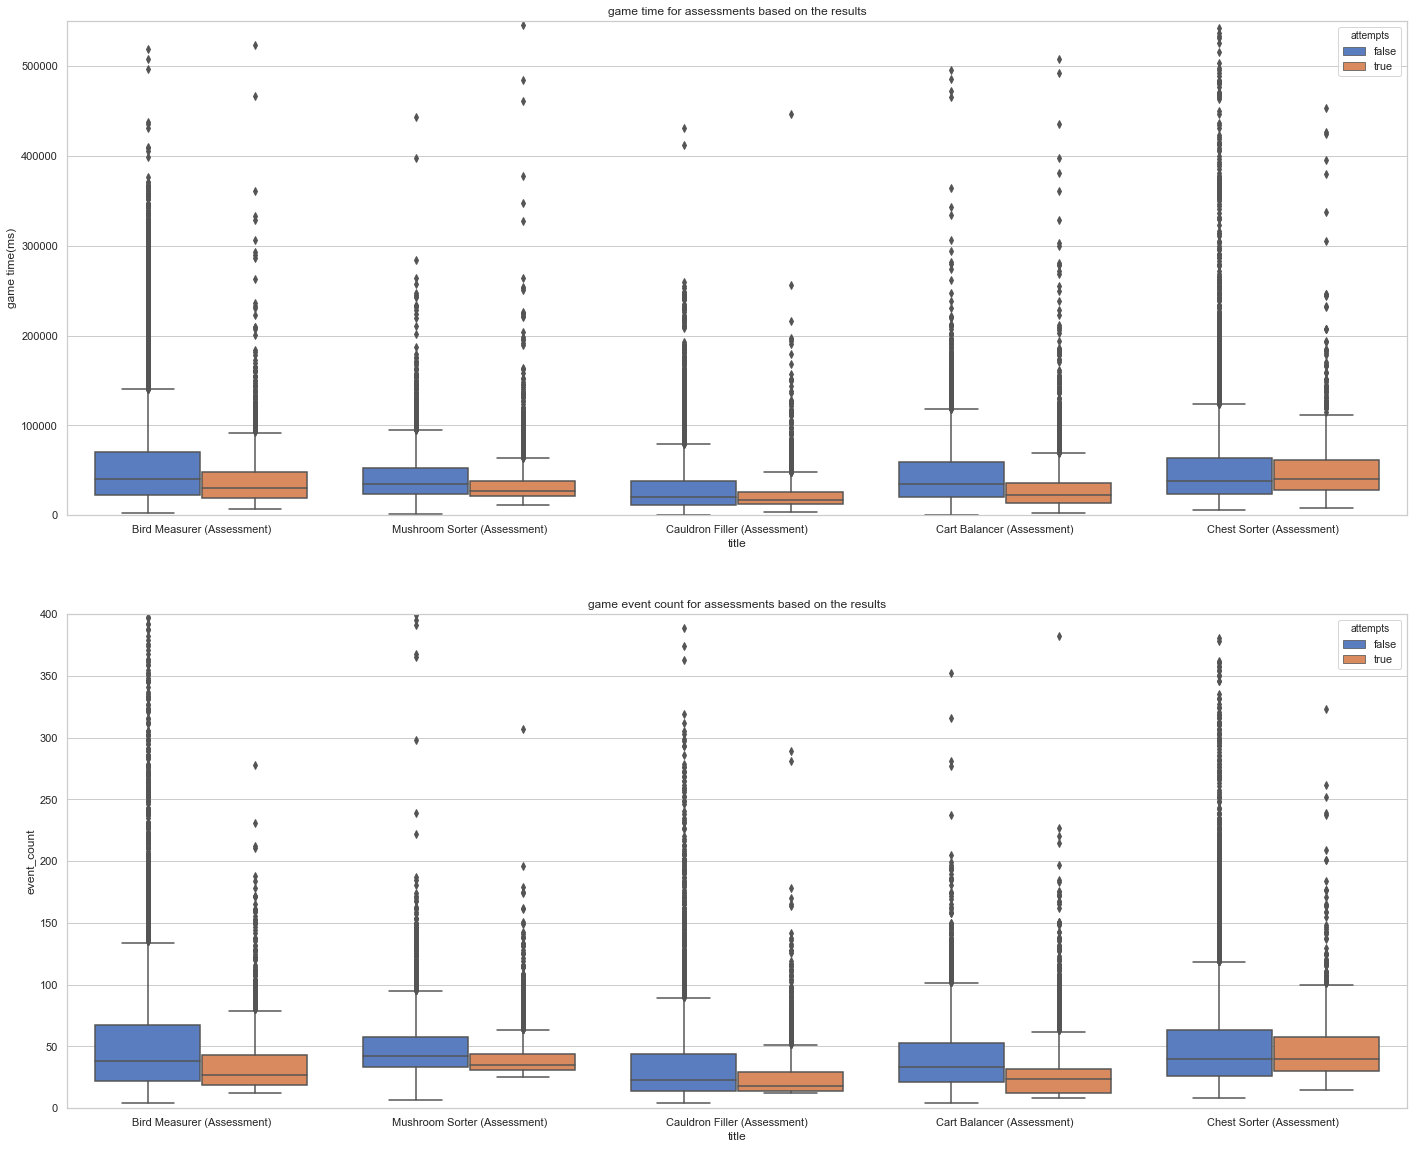

In [212]:
plot_attempts(atmp_train)

- some investigations show, some extreme large game time comes from freezing session. should be ignored.
- some assessments just have longer event lists
- corrected attemps seem to have lower event count and game time
- according to the defination, atmp_b = 1:acgroup3,atmp_b = 0.5:acgroup2,atmp_b =0: acgroup0,else 1

In [255]:
def plot_accuracyrate(atmp_train):
    pld = atmp_train.groupby(['title']).mean().reset_index()
    
    figs,ax = plt.subplots(figsize=(24,10))
    sns.barplot(x='title',y='atmp_binary',data=pld,ax = ax)
    #sns.distplot(pld.atmp_binary,ax = ax)
    #ax.set_ylim([0,2])
    

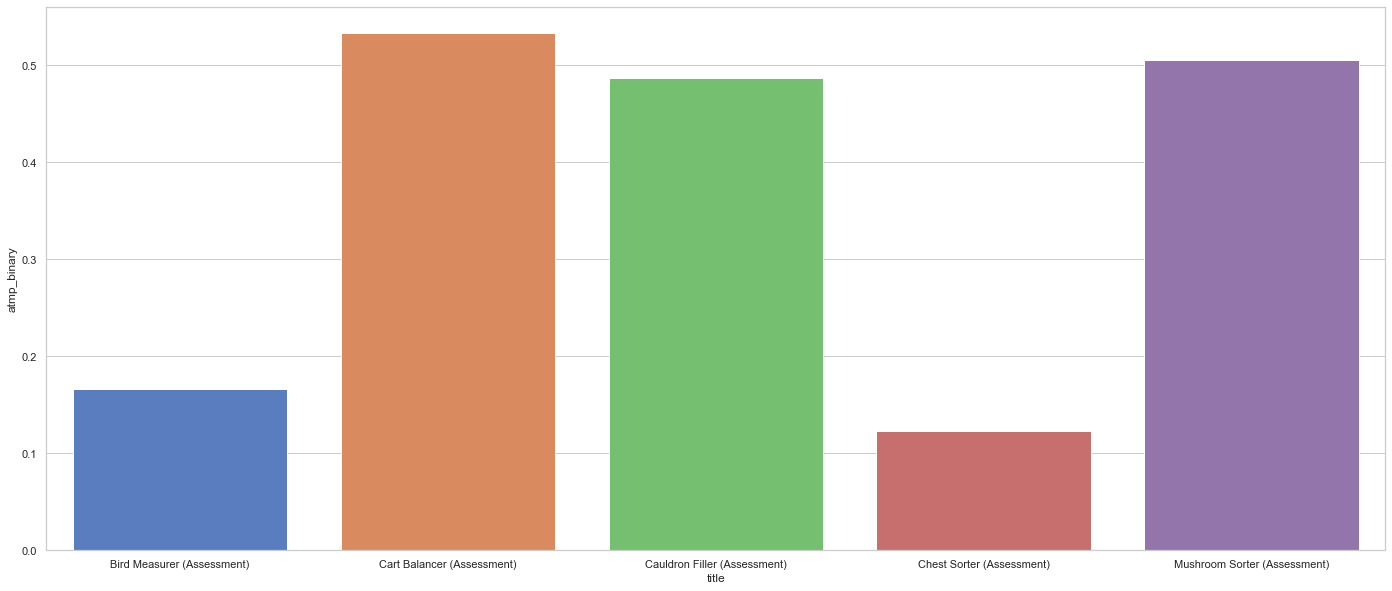

In [256]:
plot_accuracyrate(atmp_train)

- it seems the difficulty of assessments are different. bird and chest are hard, while others are fine

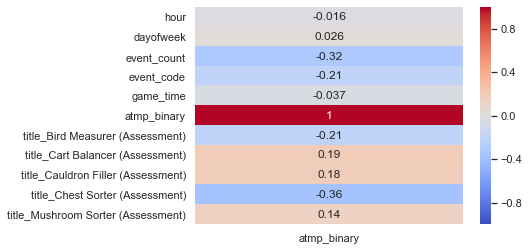

In [276]:
test = atmp_train.groupby(['title','game_session']).mean().reset_index()
sns.heatmap(pd.get_dummies(test,columns=['title']).corr()[['atmp_binary']],vmin=-1,cmap='coolwarm',xticklabels=True, yticklabels=True,annot=True)

In [309]:
def plot_histresult(atmp_train):
    # explore last assessment results from others.
    # first, get results
    temp1 = atmp_train.groupby('installation_id').game_session.count().to_frame()
    uniquein = temp1[temp1.game_session == 1].index
    multitrain = atmp_train[~atmp_train['installation_id'].isin(uniquein)]
    multitrain_mean = multitrain.groupby(['installation_id','game_session','title']).mean().reset_index()
    y = multitrain_mean.drop_duplicates(subset='installation_id',keep='last')
    x = multitrain_mean[~multitrain_mean.index.isin(y.index)].groupby('installation_id').mean()
    ff = pd.merge(x,y,how='inner',on='installation_id')
    
    fig,ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(ff.corr()[['atmp_binary_y']],vmin=-1,cmap='coolwarm',xticklabels=True, yticklabels=True,annot=True)
    ax.set(title='coorrelations between result y and factors')
    

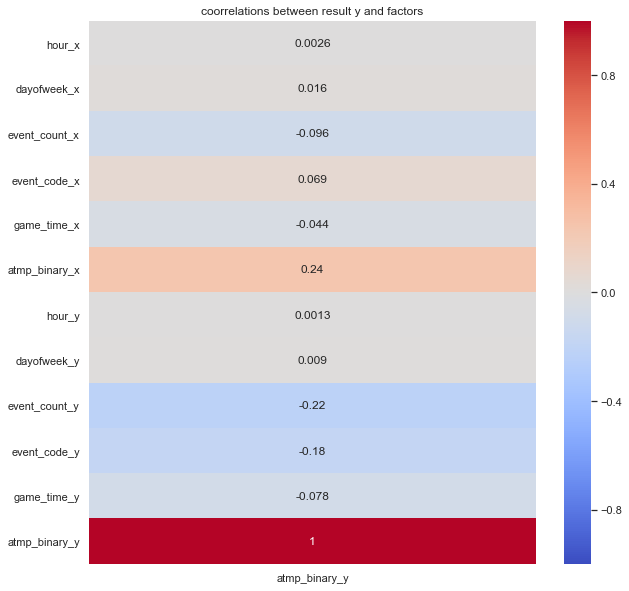

In [310]:
plot_histresult(atmp_train)


- seems like last attemp results do have close relationship with previous attempts

# results correlation explore

## now need to do some tricks to convert the training set to prediction results

In [37]:
def get_devive(train):
    # 1. we're predicting the attempts of last assessment for every installid
    # so first we need to remove other activities after the last assessment
    idlist = train['installation_id'].unique()
    greplast = train.drop_duplicates(subset = 'installation_id',keep='last').index
    dictionary = dict(zip(idlist, greplast))
    del idlist
    del greplast
    return dictionary
    

In [50]:
def train_process(train):
    # loop through devices to find index need to be dropped.
    dictionary = get_devive(train)
    train_cp = train.loc[:,['game_session','type','installation_id']]
    train_unique = train_cp.drop_duplicates(subset='game_session',keep='last')
    first = 0
    for device in dictionary:
        first += 1
        cut = train_unique[(train_unique['installation_id'] == device)]
        for idx,row in cut.iloc[::-1].iterrows():
            if row['type'] == 'Assessment':
                if first == 1:
                    rmidx = train_cp[(train_cp.index > idx) & (train_cp.index <= dictionary[device])].index
                else:
                    rmidx = rmidx.append(train_cp[(train_cp.index > idx) & (train_cp.index <= dictionary[device])].index)
                break
        if first % 100 == 0:
            print("processed",first,"ids")
    # drop the events
    print("dropping events, now we have valid training set:train")
    ptrain = train.drop(index=rmidx)
    
    return ptrain

In [51]:
ptrain = train_process(train)

processed 100 ids
processed 200 ids
processed 300 ids
processed 400 ids
processed 500 ids
processed 600 ids
processed 700 ids
processed 800 ids
processed 900 ids
processed 1000 ids
processed 1100 ids
processed 1200 ids
processed 1300 ids
processed 1400 ids
processed 1500 ids
processed 1600 ids
processed 1700 ids
processed 1800 ids
processed 1900 ids
processed 2000 ids
processed 2100 ids
processed 2200 ids
processed 2300 ids
processed 2400 ids
processed 2500 ids
processed 2600 ids
processed 2700 ids
processed 2800 ids
processed 2900 ids
processed 3000 ids
processed 3100 ids
processed 3200 ids
processed 3300 ids
processed 3400 ids
processed 3500 ids
processed 3600 ids
processed 3700 ids
processed 3800 ids
processed 3900 ids
processed 4000 ids
processed 4100 ids
processed 4200 ids


- now for each installationid, the last game session is assessment, just like test set
- in order to build trainset, we need to further remove the last assessment for each installation_id

In [331]:
def split_lastassess(ptrain):
    # to further split last assessment for each installation_id
    train_cp = ptrain.loc[:,['game_session','type','installation_id']]
    unique = train_cp.drop_duplicates(subset='game_session',keep='last')
    lastassessment = unique.drop_duplicates(subset='installation_id',keep='last')
    fullresults = ptrain[ptrain['game_session'].isin(lastassessment.game_session)]
    firstlast = fullresults.loc[:,['game_session','installation_id']].drop_duplicates(subset='installation_id',keep='first')
    dropindex = fullresults[~fullresults.index.isin(firstlast.index)].index
    opt1 = ptrain[~ptrain.index.isin(dropindex)]
    # return, 1:all full last assessment for each installation_id
    #         2:2nd- end events removed for the last assessment for each installation id, should be same withtest
    return fullresults, opt1
    

In [332]:
raw_y,train_ready = split_lastassess(ptrain)

- total of installation_id =4242 for before and after process, seems right
- game_session check seems alright
- check a random install_id 0ec92788, seems right too
- we can move on to build train and test set